In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/active_learning"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/active_learning


In [2]:
import pandas as pd
import numpy as np

**Data Loading**

In [3]:
X = pd.read_csv("data/classtotaldesc.csv",index_col=0)
X.head()

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,Bit_10,Bit_11,Bit_12,Bit_13,Bit_14,Bit_15,Bit_16,Bit_17,Bit_18,Bit_19,Bit_20,Bit_21,Bit_22,Bit_23,Bit_24,Bit_25,Bit_26,Bit_27,Bit_28,Bit_29,Bit_30,Bit_31,Bit_32,Bit_33,Bit_34,Bit_35,Bit_36,Bit_37,Bit_38,Bit_39,...,Bit_984,Bit_985,Bit_986,Bit_987,Bit_988,Bit_989,Bit_990,Bit_991,Bit_992,Bit_993,Bit_994,Bit_995,Bit_996,Bit_997,Bit_998,Bit_999,Bit_1000,Bit_1001,Bit_1002,Bit_1003,Bit_1004,Bit_1005,Bit_1006,Bit_1007,Bit_1008,Bit_1009,Bit_1010,Bit_1011,Bit_1012,Bit_1013,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
Smiles,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NC(=O)C(=O)Nc1nc(C(=O)NCc2ccc(F)cc2)c(O)c2ncccc12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
COc1ccc(/C=C2\C(=O)N(c3ccc(C(=O)O)cc3)N=C2C(F)(F)F)cc1OCc1ccc(F)cc1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Cn1ncnc1-c1cc(F)ccc1CNC(=O)c1nc(C2CCOCC2)n(C)c(=O)c1O,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
O=C1c2c(ccc(O)c2O)CN1N1Cc2ccc(O)c(O)c2S1(=O)=O,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
Cc1cc(Cl)cc2c1S(=O)(=O)N=C(C(=O)c1ccc3ccccc3c1)S2,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [4]:
X_train=X.iloc[:1961,:]
X_test=X.iloc[1961:,:]
print(X_train.shape)
print(X_test.shape)

(1961, 1024)
(490, 1024)


In [5]:
y_train=pd.read_csv("data/classtrain.csv",index_col=0)
print(y_train.iloc[:,1].value_counts())
y_train=y_train.iloc[:,1]
y_test=pd.read_csv("data/classtest.csv",index_col=0)
print(y_test.iloc[:,1].value_counts())
y_test=y_test.iloc[:,1]
#y = pd.concat([train.iloc[:,1], test.iloc[:,1]], axis=0)

0    1392
1     569
Name: classlabel, dtype: int64
0    358
1    132
Name: classlabel, dtype: int64


In [6]:
X=X_train
y=y_train

**Data Visualization**

In [7]:
RANDOM_STATE_SEED=123
from sklearn.decomposition import PCA
# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X)

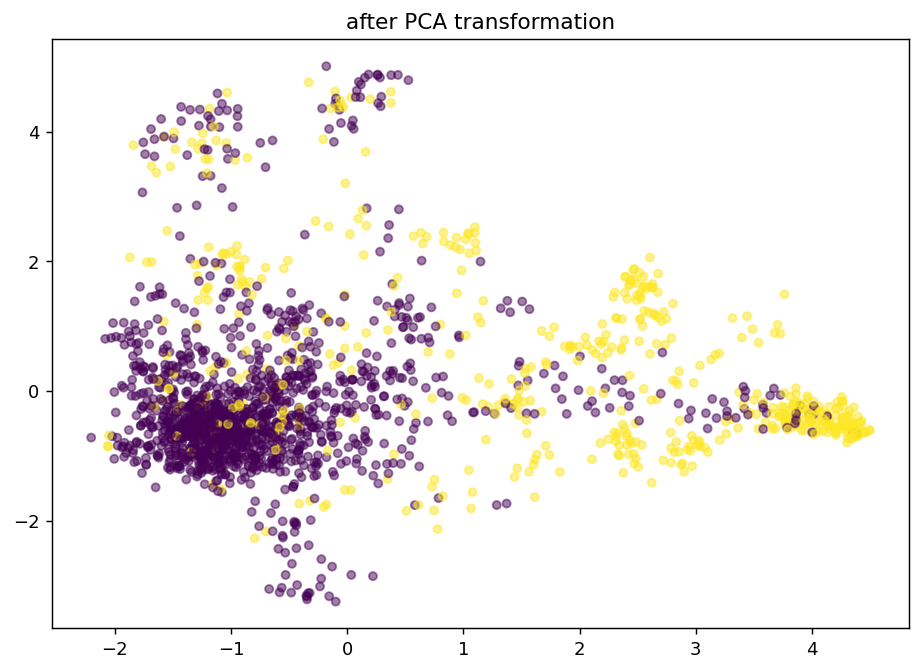

In [8]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed[:, 0], transformed[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y, s=20, alpha=0.5)
plt.title('after PCA transformation')
plt.show()

In [9]:
X=X.values
y=y.values
X_test=X_test.values
y_test=y_test.values

In [10]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=50)

X_train = X[training_indices]
y_train = y[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X, training_indices, axis=0)
y_pool = np.delete(y, training_indices, axis=0)

**Model Initialization**

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
rf=RandomForestClassifier(n_estimators=100)
svc = svm.SVC(probability=True)

learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

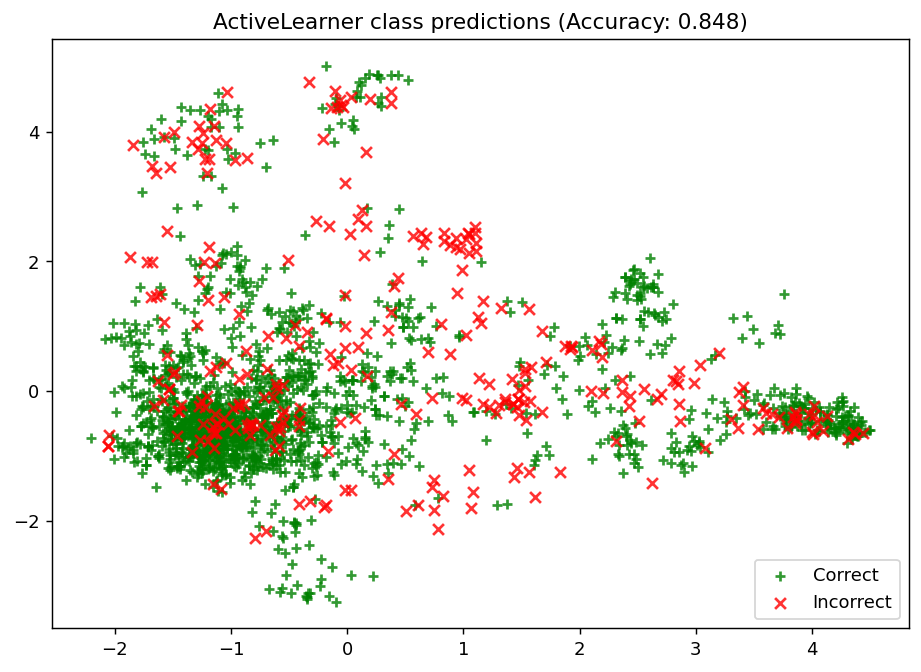

In [12]:
predictions = learner.predict(X)
is_correct = (predictions == y)
# Record our learner's score on the raw data.
unqueried_score = learner.score(X, y)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

**Querying Data**

In [13]:
N_QUERIES = 30
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)
  #print(query_index)
  # Teach our ActiveLearner model the record it has requested.
  X1, y1 = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X1, y=y1)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X, y)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.8480
Accuracy after query 2: 0.8485
Accuracy after query 3: 0.8501
Accuracy after query 4: 0.8506
Accuracy after query 5: 0.8506
Accuracy after query 6: 0.8506
Accuracy after query 7: 0.8536
Accuracy after query 8: 0.8567
Accuracy after query 9: 0.8623
Accuracy after query 10: 0.8623
Accuracy after query 11: 0.8613
Accuracy after query 12: 0.8623
Accuracy after query 13: 0.8623
Accuracy after query 14: 0.8613
Accuracy after query 15: 0.8628
Accuracy after query 16: 0.8618
Accuracy after query 17: 0.8613
Accuracy after query 18: 0.8695
Accuracy after query 19: 0.8689
Accuracy after query 20: 0.8700
Accuracy after query 21: 0.8695
Accuracy after query 22: 0.8700
Accuracy after query 23: 0.8695
Accuracy after query 24: 0.8700
Accuracy after query 25: 0.8720
Accuracy after query 26: 0.8730
Accuracy after query 27: 0.8837
Accuracy after query 28: 0.8842
Accuracy after query 29: 0.8873
Accuracy after query 30: 0.8878


**Plotting Results**

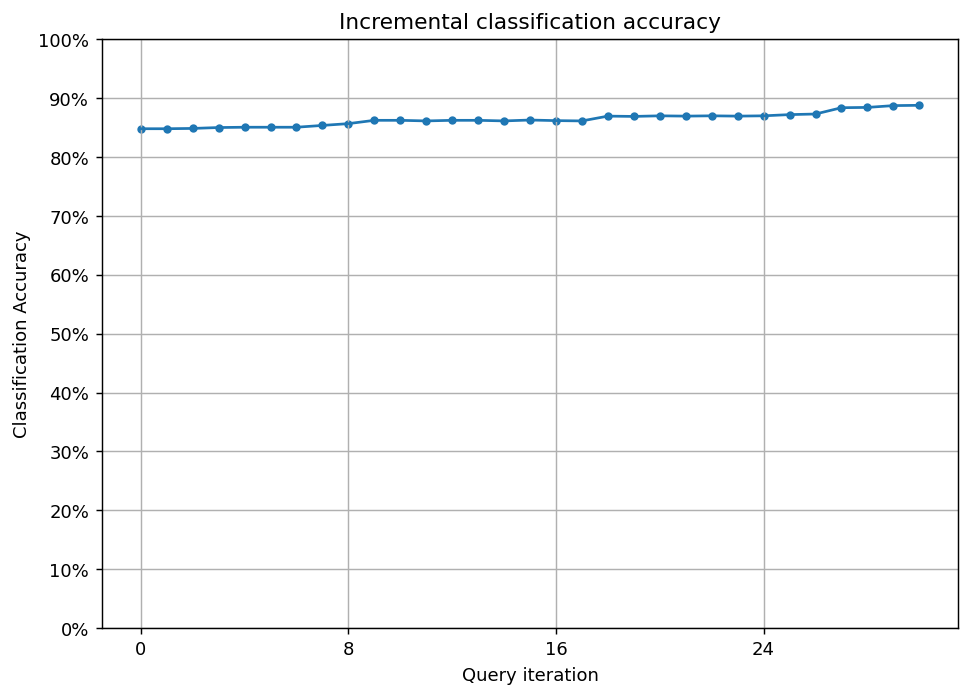

In [14]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

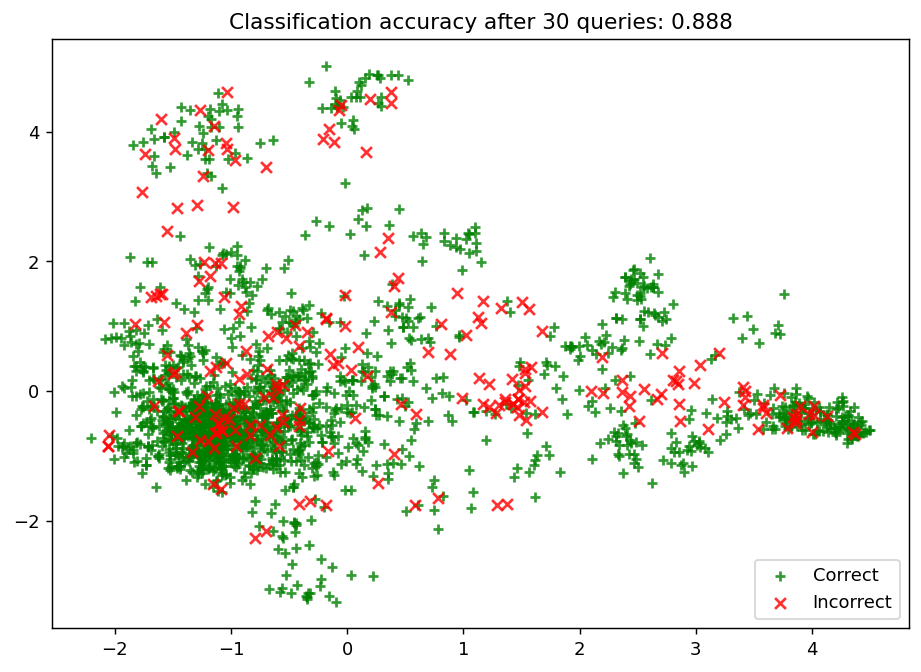

In [15]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X)
is_correct = (predictions == y)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = learner.predict(X_test)
y_true = y_test
target_names = ['class 0', 'class 1']
print("Classification Report \n")
print(classification_report(y_true, y_pred, target_names=target_names))
print("Accuracy")
print(accuracy_score(y_true, y_pred))

Classification Report 

              precision    recall  f1-score   support

     class 0       0.90      0.92      0.91       358
     class 1       0.77      0.73      0.75       132

    accuracy                           0.87       490
   macro avg       0.83      0.82      0.83       490
weighted avg       0.87      0.87      0.87       490

Accuracy
0.8673469387755102
